In [203]:
import os
import warnings
from typing import Dict, Optional, List

import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.model_selection import (
    StratifiedKFold,
    train_test_split,
    cross_validate,
)
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.covariance import MinCovDet

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    f1_score,
    matthews_corrcoef,
    confusion_matrix,
    average_precision_score,
)

from scipy.spatial import distance
from scipy.stats import chi2


In [204]:
GENE = "BRCA1"
SEED = 42

In [205]:
data = pd.read_csv("data/global/BRCA1/classified_BRCA1_3356.txt", sep="\t", na_values=["999", "999.0", 999, 999.0])
leb_data  = pd.read_csv("data/local/BRCA1/classified_BRCA1_953.txt",  sep="\t", na_values=["999", "999.0", 999, 999.0])
vus = pd.read_csv("data/local/BRCA1/vus_BRCA1_2.txt", sep="\t", na_values=["999", "999.0", 999, 999.0])

if GENE == "BRCA2":
    data = pd.read_csv("data/global/BRCA2/classified_BRCA2_4115.txt", sep="\t", na_values=["999", "999.0", 999, 999.0])
    leb_data  = pd.read_csv("data/local/BRCA2/classified_BRCA2_682.txt",  sep="\t", na_values=["999", "999.0", 999, 999.0])
    vus = pd.read_csv("data/local/BRCA2/vus_BRCA2_10.txt", sep="\t", na_values=["999", "999.0", 999, 999.0])

# uncomment for ablation results
# to_drop = ["id", "label", "Consequence", "CADD_RAW", "CADD_PHRED"]
# to_drop = ["id", "label", "Consequence"]
to_drop = ["id", "label"]
features = [x for x in data.columns if x not in to_drop]   

X = data[features]
y = data["label"]
vus_test = vus[features].copy()

X_train_benign = leb_data[leb_data["label"] == 0]
X_test_pathogenic = leb_data[leb_data["label"] == 1]

X_train_benign = X_train_benign[features]
X_test_pathogenic = X_test_pathogenic[features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [206]:
X_train.replace("999", np.nan, inplace=True)
X_test.replace("999", np.nan, inplace=True)
vus_test.replace("999", np.nan, inplace=True)
X_train_benign.replace("999", np.nan, inplace=True)
X_test_pathogenic.replace("999", np.nan, inplace=True)

In [207]:
vus_test.fillna(0, inplace=True)
X_train_benign.fillna(0, inplace=True)
X_test_pathogenic.fillna(0, inplace=True)

In [208]:
print(f"Selected Features: {len(X_train.columns)}")

Selected Features: 51


label
0     889
1    1795
Name: count, dtype: int64


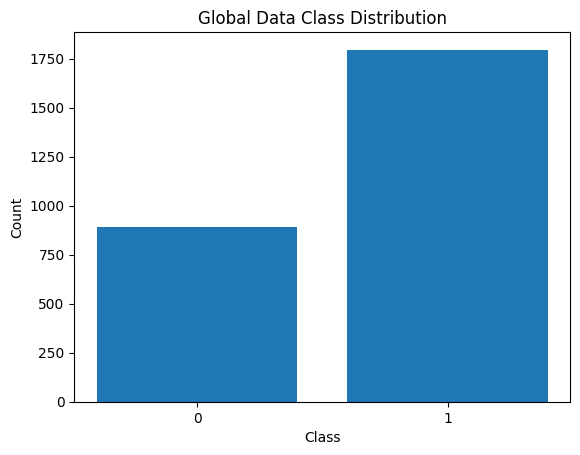

In [209]:
class_counts = y_train.value_counts().sort_index()
print(class_counts)

plt.bar(class_counts.index, class_counts.values)
plt.xticks([0, 1])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Global Data Class Distribution")
plt.show()

### Training

In [210]:
class CorrelationFilter(BaseEstimator, TransformerMixin):
    # we drop one of any pair of features whose abs(corr) > threshold
    def __init__(self, threshold=0.98):
        self.threshold = threshold

    def fit(self, X, y=None):
        df = pd.DataFrame(X)
        corr = df.corr().abs()
        upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        self.to_drop_ = [i for i in range(upper.shape[1]) 
                         if (upper.iloc[:, i] > self.threshold).any()]
        return self

    def transform(self, X):
        return np.delete(X, self.to_drop_, axis=1)

In [211]:
class DropAllNaNColumns(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        self.keep_cols_ = X.columns[~X.isna().all(axis=0)]
        return self
    def transform(self, X):
        X = pd.DataFrame(X)
        return X[self.keep_cols_]

In [212]:
def _resolved_feature_names_after_preproc(preproc, X, feature_names=None):
    n_features = X.shape[1]
    names = list(feature_names) if feature_names is not None else [f"f{i}" for i in range(n_features)]

    drop_nan = preproc.named_steps.get("drop_all_nan", None)
    if drop_nan is not None and hasattr(drop_nan, "keep_cols_"):
        # make sure to map back to the names provided
        names = [names[i] for i, col in enumerate(X.columns) if col in drop_nan.keep_cols_] \
            if hasattr(X, "columns") else list(drop_nan.keep_cols_)

    vt = preproc.named_steps.get("var_thresh", None)
    if vt is not None and hasattr(vt, "get_support"):
        keep_idx_vt = vt.get_support(indices=True)
        names = [names[i] for i in keep_idx_vt]

    cf = preproc.named_steps.get("corr_filter", None)
    if cf is not None and hasattr(cf, "to_drop_"):
        to_drop = set(cf.to_drop_)
        names = [n for i, n in enumerate(names) if i not in to_drop]

    return names



def _print_logistic_importance(clf, final_names, top_k=10, title_prefix="Logistic"):
    coefs = clf.coef_.ravel()
    order = np.argsort(np.abs(coefs))[::-1][:top_k]
    rows = []
    
    for i in order:
        sign = "+" if coefs[i] >= 0 else "-"
        rows.append((final_names[i], float(coefs[i]), sign))
        
    print(f"\n[{title_prefix}] Top {top_k} features by |coef| (with sign):")
    
    for name, coef, sign in rows:
        print(f"  {name:<30s} {sign}{abs(coef):.4f}")


def _print_tree_importance(clf, final_names, top_k=10, title_prefix="Tree"):
    if hasattr(clf, "feature_importances_"):
        imps = clf.feature_importances_
        order = np.argsort(imps)[::-1][:top_k]
        print(f"\n[{title_prefix}] Top {top_k} features by impurity importance:")
        for i in order:
            print(f"  {final_names[i]:<30s} {imps[i]:.6f}")


def _xgb_shap_importance(clf, X_trans, final_names, top_k=10):
    explainer = shap.TreeExplainer(clf)
    shap_vals = explainer.shap_values(X_trans)

    if isinstance(shap_vals, list):
        shap_vals = shap_vals[0]

    mean_abs = np.mean(np.abs(shap_vals), axis=0)
    order = np.argsort(mean_abs)[::-1][:top_k]
    rows = [(final_names[i], float(mean_abs[i])) for i in order]
    return rows


def cross_validate_models(
    pipelines: Dict[str, object],
    X_train: np.ndarray, y_train: np.ndarray,
    X_test: np.ndarray, y_test: np.ndarray,
    vus_test: Optional[np.ndarray] = None,
    feature_names: Optional[List[str]] = None,
    n_folds: int = 5,
    random_state: int = 0,
    output_dir: Optional[str] = None,
    n_jobs: int = -1
):
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)

    scoring = {
        "accuracy": "accuracy",
        "mcc": "matthews_corrcoef",
        "roc_auc": "roc_auc",
        "precision": "precision",
        "recall": "recall",
        "f1": "f1",
    }

    kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_state)

    for name, pipe in pipelines.items():
        print("\n" + "=" * 80)
        print(f"{name.upper()} — Stratified {n_folds}-fold CV")

        cv_results = cross_validate(
            pipe, X_train, y_train,
            cv=kf,
            scoring=scoring,
            return_train_score=True,
            n_jobs=n_jobs,
            error_score="raise"
        )

        def _m(metric):
            return np.mean(cv_results[f"test_{metric}"]), np.std(cv_results[f"test_{metric}"])

        def _mtr(metric):
            return np.mean(cv_results[f"train_{metric}"]), np.std(cv_results[f"train_{metric}"])

        print(" Train:")
        for m in ["accuracy", "mcc", "roc_auc", "precision", "recall", "f1"]:
            mean_, std_ = _mtr(m)
            print(f"  {m:<10s} {mean_:.4f} ± {std_:.4f}")

        print(" Valid:")
        for m in ["accuracy", "mcc", "roc_auc", "precision", "recall", "f1"]:
            mean_, std_ = _m(m)
            print(f"  {m:<10s} {mean_:.4f} ± {std_:.4f}")

        pipe_fit = clone(pipe)
        pipe_fit.fit(X_train, y_train)

        y_pred = pipe_fit.predict(X_test)
        if hasattr(pipe_fit, "predict_proba"):
            y_prob = pipe_fit.predict_proba(X_test)[:, 1]
            auc = roc_auc_score(y_test, y_prob)
        else:
            y_prob = None
            auc = np.nan

        test_metrics = {
            "precision": precision_score(y_test, y_pred, zero_division=0),
            "recall": recall_score(y_test, y_pred, zero_division=0),
            "f1": f1_score(y_test, y_pred, zero_division=0),
            "accuracy": accuracy_score(y_test, y_pred),
            "roc_auc": auc,
            "mcc": matthews_corrcoef(y_test, y_pred),
        }
        print("\n Test (held‑out):")
        for k, v in test_metrics.items():
            print(f"  {k:<10s} {v:.4f}")

        # this allows me to test models without preprocessing to see difference
        if "preproc" in pipe_fit.named_steps:
            preproc = pipe_fit.named_steps["preproc"]
            final_names = _resolved_feature_names_after_preproc(preproc, X_train, feature_names)
            Xtr_trans = preproc.transform(X_train)
        else:
            # No preproc step
            final_names = feature_names or [f"f{i}" for i in range(X_train.shape[1])]
            Xtr_trans = X_train

        clf = pipe_fit.named_steps.get("clf")

        if isinstance(clf, LogisticRegression):
            _print_logistic_importance(clf, final_names, top_k=10, title_prefix="LogisticRegression")

        if isinstance(clf, XGBClassifier):
            rows = _xgb_shap_importance(clf, Xtr_trans, final_names, top_k=10)
            print("\n[XGBoost] Top 10 features by mean |SHAP|:")
            for name_i, val in rows:
                print(f"  {name_i:<30s} {val:.6f}")

        if isinstance(clf, DecisionTreeClassifier):
            _print_tree_importance(clf, final_names, top_k=10, title_prefix="DecisionTree")
            if output_dir:
                fig = plt.figure(figsize=(18, 10))
                plot_tree(
                    clf,
                    feature_names=final_names,
                    class_names=["Benign", "Pathogenic"],
                    filled=True,
                    impurity=True,
                    rounded=True
                )
                out_path = os.path.join(output_dir, f"{name}_tree.png")
                fig.tight_layout()
                fig.savefig(out_path, dpi=200)
                plt.close(fig)
                print(f"  [Saved tree plot] {out_path}")

        if vus_test is not None:
            try:
                vus_preds = pipe_fit.predict(vus_test)
                if hasattr(pipe_fit, "predict_proba"):
                    vus_probs = pipe_fit.predict_proba(vus_test)[:, 1]
                else:
                    vus_probs = None
                print("\n VUS predictions:", vus_preds)
                if vus_probs is not None:
                    print(" VUS probabilities:", vus_probs)
            except Exception as e:
                print(f"\n [WARN] VUS inference failed for {name}: {e}")

In [213]:
preprocessor = Pipeline([
	("drop_all_nan", DropAllNaNColumns()),
    # ("imputer", SimpleImputer(strategy="median")),
    ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
    ("var_thresh", VarianceThreshold(threshold=1e-5)),
    ("corr_filter", CorrelationFilter(threshold=0.98)),
    ("scaler", StandardScaler()),
])

In [214]:
pipelines = {
    "xgboost": Pipeline([
        ("preproc", preprocessor),
        
        ("clf", XGBClassifier(
			booster="gbtree",
			objective="binary:logistic",
			learning_rate=0.3,
			max_depth=3,
			min_child_weight=1,
			subsample=1,
			colsample_bytree=1,
			n_estimators=100,
			eval_metric="logloss",
			random_state = SEED
        )),
    ]),
    "logistic_lbfgs": Pipeline([
		("preproc", preprocessor),
		("clf", LogisticRegression(
			penalty="l2",
			solver="lbfgs",
			class_weight="balanced",
			C=1.0,
			max_iter=750,
			random_state=SEED
		)),
	]),
    "decision_tree": Pipeline([
		("preproc", preprocessor),
		("clf", DecisionTreeClassifier(
				criterion="gini",
				max_depth=3,
				class_weight="balanced",
				min_samples_split=40,
				min_samples_leaf=20,
				random_state=SEED
			)),
	])
}

In [215]:
# warnings.filterwarnings("ignore", category=UserWarning)

cross_validate_models(
    pipelines=pipelines,
    X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test,
    vus_test=vus_test,
    feature_names=list(features),
    n_folds=5,
    random_state=SEED,
    output_dir="./model_outputs",
)



XGBOOST — Stratified 5-fold CV
 Train:
  accuracy   1.0000 ± 0.0000
  mcc        1.0000 ± 0.0000
  roc_auc    1.0000 ± 0.0000
  precision  1.0000 ± 0.0000
  recall     1.0000 ± 0.0000
  f1         1.0000 ± 0.0000
 Valid:
  accuracy   0.9944 ± 0.0031
  mcc        0.9874 ± 0.0070
  roc_auc    0.9998 ± 0.0002
  precision  0.9956 ± 0.0028
  recall     0.9961 ± 0.0028
  f1         0.9958 ± 0.0023

 Test (held‑out):
  precision  0.9978
  recall     0.9956
  f1         0.9967
  accuracy   0.9955
  roc_auc    0.9999
  mcc        0.9899

[XGBoost] Top 10 features by mean |SHAP|:
  Consequence                    3.010039
  Maximum_allele_frequency       2.419631
  CADD_PHRED                     1.547066
  Variant_length                 1.501168
  Exon_number                    1.143025
  Variant_position               0.419353
  Intron_number                  0.360436
  SIFT_Score                     0.131762
  M.CAP_rankscore                0.076911
  HUVEC_fitCons_rankscore        0.076256

 

In [216]:
print(f"Num pathogenic: {len(X_test_pathogenic)}")
print(f"Num benign train: {len(X_train_benign)}")

Num pathogenic: 8
Num benign train: 945


Threshold: 22.967
Specificity: 1.000 | Recall: 1.000
Accuracy: 1.000 | F1: 1.000
AUROC: 1.000 | AUPRC: 1.000
189
756
945


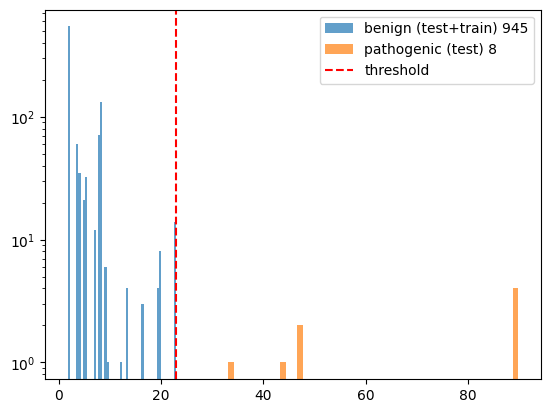


[Chi-square p-values for pathogenic test entries]
Degrees of freedom (k): 48
Count p<0.05: 8/8 | p<0.01: 8/8

Index	Mahalanobis_d	p_value(chi2_sf)
0	47.0231		0.000e+00
1	44.2763		0.000e+00
2	89.8933		0.000e+00
3	33.0484		2.492e-197
4	47.0123		0.000e+00
5	89.8291		0.000e+00
6	89.8291		0.000e+00
7	89.8291		0.000e+00


In [217]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

X_train_benign, X_test_benign = train_test_split(
    X_train_benign, test_size=0.2, random_state=42, shuffle=True
)

X_test_pathogenic = X_test_pathogenic.copy()

common = X_train_benign.columns.intersection(
    X_test_benign.columns
).intersection(X_test_pathogenic.columns)

Xtr = X_train_benign[common].copy()
Xtb = X_test_benign[common].copy()
Xtp = X_test_pathogenic[common].copy()

non_allnan = Xtr.columns[Xtr.notna().any(axis=0)]
Xtr = Xtr[non_allnan]; Xtb = Xtb[non_allnan]; Xtp = Xtp[non_allnan]
non_const = Xtr.columns[Xtr.nunique() > 1]
Xtr = Xtr[non_const]; Xtb = Xtb[non_const]; Xtp = Xtp[non_const]

Xtr = Xtr.fillna(Xtr.median())
Xtb = Xtb.fillna(Xtr.median())
Xtp = Xtp.fillna(Xtr.median())

scaler = StandardScaler().fit(Xtr)
Ztr = scaler.transform(Xtr)
Ztb = scaler.transform(Xtb)
Ztp = scaler.transform(Xtp)

robust_cov = MinCovDet().fit(Ztr)

def mahal_batch(Z):
    return np.array([
        distance.mahalanobis(z, robust_cov.location_, robust_cov.precision_)
        for z in Z
    ])

d_tr = mahal_batch(Ztr)
d_tb = mahal_batch(Ztb)
d_tp = mahal_batch(Ztp)

train_threshold = np.percentile(d_tb, 99.5)

y_scores = np.concatenate([d_tb, d_tp])
y_true   = np.concatenate([np.zeros(len(d_tb)), np.ones(len(d_tp))])
y_pred   = (y_scores > train_threshold).astype(int)

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

print(f"Threshold: {train_threshold:.3f}")
print(f"Specificity: {tn/(tn+fp):.3f} | Recall: {tp/(tp+fn):.3f}")
print(f"Accuracy: {accuracy_score(y_true, y_pred):.3f} | F1: {f1_score(y_true, y_pred):.3f}")
print(f"AUROC: {roc_auc_score(y_true, y_scores):.3f} | AUPRC: {average_precision_score(y_true, y_scores):.3f}")

joined = np.concatenate((d_tb, d_tr))
print(len(d_tb))
print(len(d_tr))
print(len(joined))
plt.hist(joined, bins=50, alpha=0.7, label=f"benign (test+train) {len(joined)}")
plt.hist(d_tp, bins=50, alpha=0.7, label=f"pathogenic (test) {len(d_tp)}")
plt.axvline(train_threshold, color='red', linestyle='--', label='threshold')
plt.yscale("log")
plt.legend()
plt.show()

# Under MVN assumptions, squared Mahalanobis distances ~ chi2_k,
# where k is the feature dimensionality after preprocessing.
k = Ztr.shape[1]
pvals_tp = chi2.sf(d_tp**2, df=k)  # survival function = 1 - CDF

n05 = np.sum(pvals_tp < 0.05)
n01 = np.sum(pvals_tp < 0.01)
print("\n[Chi-square p-values for pathogenic test entries]")
print(f"Degrees of freedom (k): {k}")
print(f"Count p<0.05: {n05}/{len(pvals_tp)} | p<0.01: {n01}/{len(pvals_tp)}")

print("\nIndex\tMahalanobis_d\tp_value(chi2_sf)")
for i, (d_i, p_i) in enumerate(zip(d_tp, pvals_tp)):
    print(f"{i}\t{d_i:.4f}\t\t{p_i:.3e}")

## Anomaly Detection Inference on Lebanese VUS

In [218]:
common_cols = X_train_benign.columns.intersection(vus_test.columns)
vus_test = vus_test[common_cols]
X_train_sub = X_train_benign[common_cols]

X_all = pd.concat([X_train_sub, vus_test], axis=0)

X_all = X_all.dropna(axis=1, how='all')
X_all = X_all.loc[:, X_all.nunique() > 1]

X_all = X_all.fillna(X_all.median())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all)
X_train_scaled = X_scaled[:len(X_train_sub)]
X_vus_scaled = X_scaled[len(X_train_sub):]


mahal_scores_vus = mahal_batch(X_vus_scaled)

anomalous_flags = np.array(mahal_scores_vus) > train_threshold

vus_results = pd.DataFrame({
    "Mahalanobis_score": mahal_scores_vus,
    "Predicted_anomaly": anomalous_flags
})

print(vus_results.sort_values("Mahalanobis_score", ascending=False).head(10))

   Mahalanobis_score  Predicted_anomaly
0          16.818521              False
1           9.541940              False


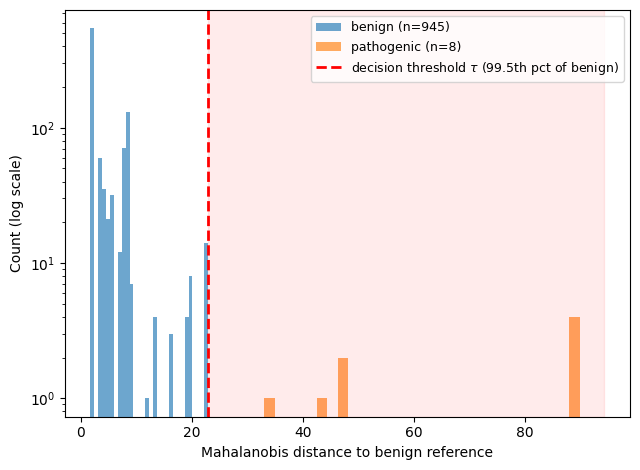

In [219]:
LEGEND_OUTSIDE = False
INCLUDE_THRESHOLD_IN_LEGEND = True
SHADE_ANOMALY_REGION = True
SAVE_FIG = False
SAVE_PATH = "assets/anomaly_detection_mahalanobis.png"
DPI = 300

benign_mahal = sorted(joined)
mahal_scores = sorted(d_tp)

max_val = max(max(benign_mahal), max(mahal_scores)) * 1.02
bins = np.linspace(0, max_val, 50)

fig, ax = plt.subplots(figsize=(6.5, 4.8))

ax.hist(benign_mahal, bins=30, alpha=0.65, label=f"benign (n={len(benign_mahal)})")
ax.hist(mahal_scores, bins=30, alpha=0.65, label=f"pathogenic (n={len(mahal_scores)})")

line_label = r'decision threshold $\tau$ (99.5th pct of benign)' if INCLUDE_THRESHOLD_IN_LEGEND else None
ax.axvline(train_threshold, color='red', linestyle='--', linewidth=2, label=line_label)

if not INCLUDE_THRESHOLD_IN_LEGEND:
    ax.text(train_threshold, 0.95, r'$\tau$ (99.5th pct of benign)',
            rotation=0, va='center', ha='left', transform=ax.get_xaxis_transform())

if SHADE_ANOMALY_REGION:
    ax.axvspan(train_threshold, ax.get_xlim()[1], color='red', alpha=0.08)

ax.set_yscale("log")
ax.set_xlabel("Mahalanobis distance to benign reference")
ax.set_ylabel("Count (log scale)")

handles, labels = ax.get_legend_handles_labels()
if LEGEND_OUTSIDE:
    ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.02, 1.0),
              borderaxespad=0., frameon=True, fontsize=9)
else:
    ax.legend(handles, labels, loc='upper right', frameon=True, fontsize=9)

plt.tight_layout()

if SAVE_FIG:
    fig.savefig(SAVE_PATH, dpi=DPI, bbox_inches="tight")

plt.show()
